
### **Importing libraries**
---


In [2]:
import pandas as pd
import numpy as np
!pip install geopandas
import geopandas as gpd
from shapely.geometry import Point
!pip install folium
import folium

import matplotlib.pyplot as plt
import seaborn as sns

!pip install lightgbm
from sklearn.ensemble import  RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None
!pip install fasteda
from fasteda import fast_eda
from lightgbm import early_stopping
!pip install optuna
import optuna
#from sklearn.model_selection import GridSearchCV
!pip install haversine
from haversine import haversine

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


C:\Users\mehdi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **Reading dataset**


---



In [3]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

### **EDA**


---



Here we are finding the columns with most null values and dropping them

In [4]:
null_counts = train.isnull().sum()

# To see the percentage of null values in each column
null_percentages = (train.isnull().sum() / len(train)) * 100

# To see the null values summary in a single DataFrame
null_summary = pd.concat([null_counts, null_percentages], axis=1)
null_summary.columns = ['Null Count', 'Null Percentage']

print(null_summary)

                                                    Null Count  \
ID_LAT_LON_YEAR_WEEK                                         0   
latitude                                                     0   
longitude                                                    0   
year                                                         0   
week_no                                                      0   
SulphurDioxide_SO2_column_number_density                 14609   
SulphurDioxide_SO2_column_number_density_amf             14609   
SulphurDioxide_SO2_slant_column_number_density           14609   
SulphurDioxide_cloud_fraction                            14609   
SulphurDioxide_sensor_azimuth_angle                      14609   
SulphurDioxide_sensor_zenith_angle                       14609   
SulphurDioxide_solar_azimuth_angle                       14609   
SulphurDioxide_solar_zenith_angle                        14609   
SulphurDioxide_SO2_column_number_density_15km            14609   
CarbonMono

In [5]:
columns_with_high_null_percentage = null_summary[null_summary['Null Percentage'] > 80]
column_names_with_high_null_percentage = columns_with_high_null_percentage.index.tolist()
train.drop(column_names_with_high_null_percentage, axis=1, inplace=True)
test.drop(column_names_with_high_null_percentage, axis=1, inplace=True)
train.fillna(train.mean(), inplace=True)

I noticed there is skewness in our target value 'emission' so i used the cubic root to make it better

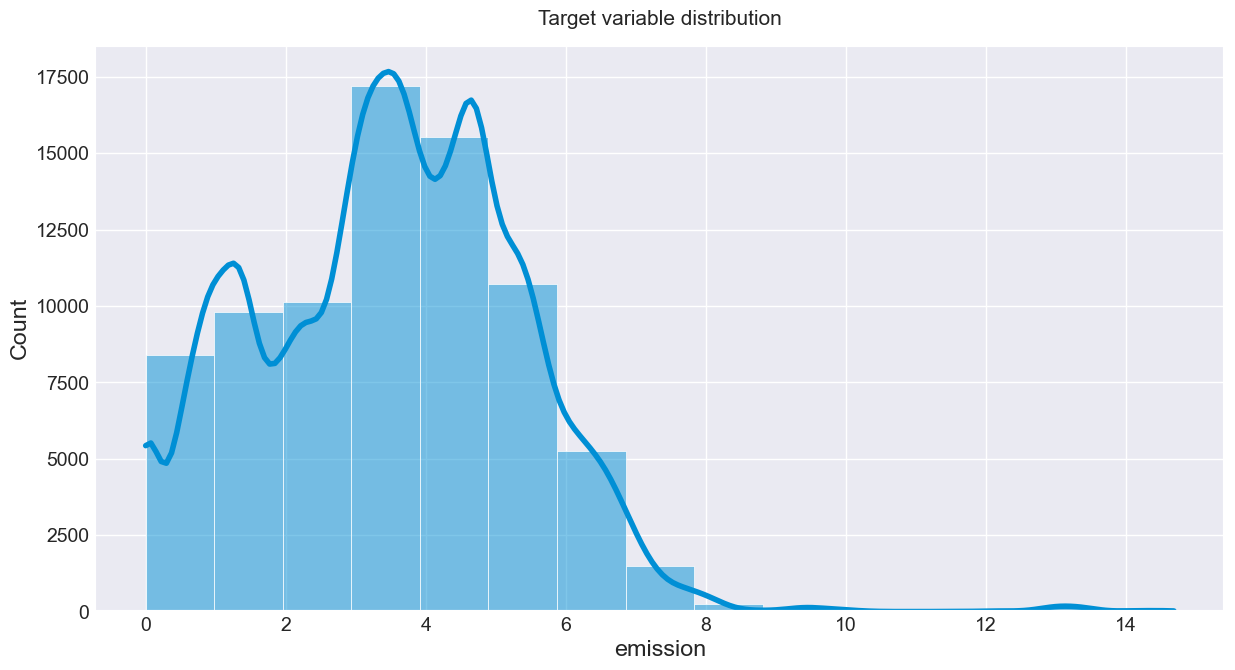

None

10.173825825101622

In [6]:
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(np.cbrt(train.emission), kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train.emission.skew())

### **Data Preprocessing and Feature Engineering**


---

I used some code from this [notebook](https://www.kaggle.com/code/yaaangzhou/en-playground-s3-e20-eda-modeling#-4.-Feature-Engineering-).
We used clustering and different distances to different locations. In addition to other features like rotating coordinates, covid, seasons, holidays ...


In [7]:
train_df=train[['ID_LAT_LON_YEAR_WEEK',"emission"]]
train['emission_cubicroot']=np.cbrt(train['emission'])
#train['emission_log']=np.log(train['emission']+1)


In [8]:
rwanda_center = (-1.9607, 29.9707)
park_biega = (-1.8866, 28.4518)
kirumba = (-0.5658, 29.1714)
massif = (-3.42, 28.592)
lake = (-2.0073, 31.6269)

def cluster_features(df, cluster_centers):
    for i, cc in enumerate(cluster_centers.values()):
        df[f'cluster_{i}'] = df.apply(lambda x: haversine((x['latitude'], x['longitude']), cc, unit='ft'), axis=1)
    return df

In [9]:
# Calculate the average monthly sales for non-virus years (2019 and 2021)
avg_emission_non_virus = train[train['year'].isin((2019,2021))].groupby('week_no')['emission'].mean()

# Calculate the average monthly for virus year (2020)
avg_emission_virus = train[train['year'] == 2020].groupby('week_no')['emission'].mean()

# Calculate the ratios for each month
ratios_for_weeks = avg_emission_non_virus/avg_emission_virus

# Multiply the num_sold column for each row in 2020 by the corresponding ratio for the week of that row
train.loc[train['year'] == 2020, 'emission'] *= train['week_no'].map(ratios_for_weeks)

train.loc[(train['week_no'] == 52) & (train['year'] == 2020), 'emission'] = np.power(train.loc[(train['week_no'] == 52) & (train['year'] == 2020), 'emission'], 1/1.5)

In [10]:
def preprocessing(df):
    df['rot_15_x'] = (np.cos(np.radians(15)) * df['longitude']) + \
                        (np.sin(np.radians(15)) * df['latitude'])

    df['rot_15_y'] = (np.cos(np.radians(15)) * df['latitude']) + \
                        (np.sin(np.radians(15)) * df['longitude'])

    df['rot_30_x'] = (np.cos(np.radians(30)) * df['longitude']) + \
                        (np.sin(np.radians(30)) * df['latitude'])
    df['rot_30_y'] = (np.cos(np.radians(30)) * df['latitude']) + \
                        (np.sin(np.radians(30)) * df['longitude'])

    for col, coors in zip(
        ['dist_rwanda', 'dist_park', 'dist_kirumba', 'dist_massif', 'dist_lake'],
        [rwanda_center, park_biega, kirumba, massif, lake]):
        df[col] = df.apply(lambda x: haversine((x['latitude'], x['longitude']), coors, unit='ft'), axis=1)

    df['is_covid'] = (df['year'] == 2020) & (df['week_no'] > 8)
    df['is_lockdown'] = (df['year'] == 2020) & ((df['week_no'].isin([9,10,11,12,13,14,15,16])))
    df['week_no_sin'] = np.sin(df['week_no']*(2*np.pi/52))
    df['week_no_sin'] = np.sin(df['week_no']*(2*np.pi/52))
    df['season'] = df['week_no'].apply(lambda x: 1 if 49 <= x <= 8 else 2 if 9 <= x <= 21 else 3 if 22 <= x <= 34 else 4)
    df['holidays'] = (df['week_no'].isin([0, 51, 12, 30]))


    df.fillna(df.mean(), inplace=True)

    return df

train = preprocessing(train)
test = preprocessing(test)

coordinates = train[['latitude', 'longitude']].values
clustering = KMeans(n_clusters=12, max_iter=1000, random_state=42).fit(coordinates)
cluster_centers = {i: tuple(centroid) for i, centroid in enumerate(clustering.cluster_centers_)}
train = cluster_features(train, cluster_centers)
test = cluster_features(test, cluster_centers)


Here i took the top 60 features that correlates with emission

In [11]:
top60_corrs = abs(train.corr()['emission']).sort_values(ascending = False).head(60)
corr=top60_corrs.index.tolist()
corr.append('week_no')
corr.append('ID_LAT_LON_YEAR_WEEK')
train=train[corr]
corr.remove('emission')
corr.remove('emission_cubicroot')
test = test[corr]
corr

['dist_rwanda',
 'cluster_2',
 'cluster_8',
 'cluster_0',
 'cluster_6',
 'cluster_3',
 'dist_lake',
 'cluster_1',
 'longitude',
 'rot_15_x',
 'cluster_10',
 'rot_30_x',
 'cluster_9',
 'rot_30_y',
 'cluster_5',
 'dist_park',
 'Cloud_surface_albedo',
 'CarbonMonoxide_CO_column_number_density',
 'cluster_11',
 'rot_15_y',
 'Formaldehyde_tropospheric_HCHO_column_number_density_amf',
 'CarbonMonoxide_H2O_column_number_density',
 'dist_massif',
 'Formaldehyde_tropospheric_HCHO_column_number_density',
 'cluster_7',
 'NitrogenDioxide_sensor_altitude',
 'SulphurDioxide_sensor_azimuth_angle',
 'NitrogenDioxide_sensor_azimuth_angle',
 'Formaldehyde_HCHO_slant_column_number_density',
 'Formaldehyde_sensor_azimuth_angle',
 'NitrogenDioxide_cloud_fraction',
 'Ozone_O3_column_number_density',
 'latitude',
 'holidays',
 'Ozone_solar_zenith_angle',
 'UvAerosolIndex_solar_zenith_angle',
 'is_lockdown',
 'Cloud_solar_zenith_angle',
 'NitrogenDioxide_solar_azimuth_angle',
 'Cloud_sensor_zenith_angle',
 'C

In [12]:
train['location'] = [str(x) + '_' + str(y) for x, y in zip(train.latitude, train.longitude)]
test['location'] = [str(x) + '_' + str(y) for x, y in zip(test.latitude,test.longitude)]

In [13]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    print(average)
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [14]:
# Calculate the number of zero emissions for each row
zero_emissions_count_per_location = train.groupby('location')['emission'].apply(lambda x: (x == 0).sum()).reset_index()

# Define a threshold for the majority of zero emissions
filtered_df=zero_emissions_count_per_location[zero_emissions_count_per_location['emission'] >= 150]
# Get the 'location' column values of the filtered rows
locations_with_majority_zero = filtered_df['location'].tolist()

# print(locations_with_majority_zero)

In [15]:
train_eng = train.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True)
test_eng = test.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True)
train_eng.head()

,emission,emission_cubicroot,dist_rwanda,cluster_2,cluster_8,cluster_0,cluster_6,cluster_3,dist_lake,cluster_1,longitude,rot_15_x,cluster_10,rot_30_x,cluster_9,rot_30_y,cluster_5,dist_park,Cloud_surface_albedo,CarbonMonoxide_CO_column_number_density,cluster_11,rot_15_y,Formaldehyde_tropospheric_HCHO_column_number_density_amf,CarbonMonoxide_H2O_column_number_density,dist_massif,Formaldehyde_tropospheric_HCHO_column_number_density,cluster_7,NitrogenDioxide_sensor_altitude,SulphurDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_azimuth_angle,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_sensor_azimuth_angle,NitrogenDioxide_cloud_fraction,Ozone_O3_column_number_density,latitude,holidays,Ozone_solar_zenith_angle,UvAerosolIndex_solar_zenith_angle,is_lockdown,Cloud_solar_zenith_angle,NitrogenDioxide_solar_azimuth_angle,Cloud_sensor_zenith_angle,CarbonMonoxide_solar_zenith_angle,SulphurDioxide_SO2_slant_column_number_density,Formaldehyde_solar_azimuth_angle,SulphurDioxide_SO2_column_number_density_15km,SulphurDioxide_solar_azimuth_angle,year,Ozone_O3_column_number_density_amf,Ozone_O3_effective_temperature,CarbonMonoxide_cloud_height,NitrogenDioxide_absorbing_aerosol_index,SulphurDioxide_SO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,CarbonMonoxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,UvAerosolIndex_sensor_zenith_angle,Cloud_cloud_top_pressure,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_stratospheric_NO2_column_number_density,week_no,ID_LAT_LON_YEAR_WEEK,location
0,3.75099,1.55375,584571.87390,689891.75600,411199.13245,476641.14394,810804.14309,744007.76884,1012319.80621,625854.21066,29.29000,28.15997,947420.03740,25.11088,212691.13492,14.20333,841201.16885,587934.30305,0.27229,0.03537,563672.72614,7.08819,0.86323,1589.02454,1091677.45216,0.00012,823162.95903,829994.22447,-98.59389,-15.93770,0.00004,-98.59389,0.09701,0.11593,-0.51000,True,30.75213,30.75213,False,30.75214,-84.26008,35.63242,25.96521,-0.00007,-130.05080,-0.00003,-130.05080,2019,2.50661,225.73114,4061.09814,-1.81216,-0.00011,0.00010,-149.87556,28.31639,35.63242,53534.73242,8922.56899,0.00003,0,ID_-0.510_29.290_2019_00,-0.51_29.29
1,4.02518,1.59072,584571.87390,689891.75600,411199.13245,476641.14394,810804.14309,744007.76884,1012319.80621,625854.21066,29.29000,28.15997,947420.03740,25.11088,212691.13492,14.20333,841201.16885,587934.30305,0.25683,0.03653,563672.72614,7.08819,1.17283,1772.57441,1091677.45216,0.00017,823162.95903,829859.96037,16.59286,5.47104,0.00014,4.67884,0.06704,0.11678,-0.51000,False,28.21366,28.57363,False,27.25178,-138.34391,39.55763,29.56200,0.00001,-141.81483,0.00001,-140.87443,2019,2.65770,226.17217,1869.04041,-1.93539,0.00002,0.00009,-140.15805,30.05426,43.48533,63790.29624,7311.86914,0.00003,1,ID_-0.510_29.290_2019_01,-0.51_29.29
2,4.23138,1.61744,584571.87390,689891.75600,411199.13245,476641.14394,810804.14309,744007.76884,1012319.80621,625854.21066,29.29000,28.15997,947420.03740,25.11088,212691.13492,14.20333,841201.16885,587934.30305,0.25110,0.03534,563672.72614,7.08819,1.17547,2703.23680,1091677.45216,0.00008,823162.95903,829527.12500,72.79584,72.79584,0.00002,-41.36358,0.07213,0.11704,-0.51000,False,30.27330,30.27330,False,26.19330,-150.19176,30.40182,31.58684,0.00038,-135.66716,0.00015,-150.19176,2019,2.61910,227.46929,2809.13839,-2.75437,0.00051,0.00008,-133.68371,23.20642,41.26903,55923.79055,7311.86914,0.00003,2,ID_-0.510_29.290_2019_02,-0.51_29.29
3,4.30529,1.62680,584571.87390,689891.75600,411199.13245,476641.14394,810804.14309,744007.76884,1012319.80621,625854.21066,29.29000,28.15997,947420.03740,25.11088,212691.13492,14.20333,841201.16885,587934.30305,0.26204,0.03679,563672.72614,7.08819,1.25413,2076.07333,1091677.45216,0.00013,823162.95903,829994.22447,-7.92587,-15.93770,0.00008,-9.39609,0.09701,0.11643,-0.51000,False,26.93648,26.93648,False,28.82915,-84.26008,24.38036,24.81070,0.00004,-84.60584,0.00001,-83.83317,2019,2.52582,225.58944,3917.70787,-1.81216,0.00005,0

### **Dataset split**


---



In [16]:
train_eng['emission_cubicroot'],avg,dev=Normalize(train_eng,'emission_cubicroot')
X = train_eng.drop(['ID_LAT_LON_YEAR_WEEK','emission','emission_cubicroot'], axis = 1).fillna(train_eng.mean())
y = train_eng.emission_cubicroot


3.511890921915729


In [17]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.22,stratify = X['location'])

In [18]:
X_train.drop(['location'],axis=1,inplace=True)
X_test.drop(['location'],axis=1,inplace=True)
X.drop(['location'],axis=1,inplace=True)
# X_train = X_train.sort_values(by = ['year', 'week_no'], ignore_index = True)
# X_test = X_test.sort_values(by = ['year', 'week_no'], ignore_index = True)

In [19]:
test_df=test_eng.drop(['ID_LAT_LON_YEAR_WEEK','location',], axis = 1)
test_df.fillna(test_df.mean(), inplace=True)
test_df.head()

,dist_rwanda,cluster_2,cluster_8,cluster_0,cluster_6,cluster_3,dist_lake,cluster_1,longitude,rot_15_x,cluster_10,rot_30_x,cluster_9,rot_30_y,cluster_5,dist_park,Cloud_surface_albedo,CarbonMonoxide_CO_column_number_density,cluster_11,rot_15_y,Formaldehyde_tropospheric_HCHO_column_number_density_amf,CarbonMonoxide_H2O_column_number_density,dist_massif,Formaldehyde_tropospheric_HCHO_column_number_density,cluster_7,NitrogenDioxide_sensor_altitude,SulphurDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_azimuth_angle,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_sensor_azimuth_angle,NitrogenDioxide_cloud_fraction,Ozone_O3_column_number_density,latitude,holidays,Ozone_solar_zenith_angle,UvAerosolIndex_solar_zenith_angle,is_lockdown,Cloud_solar_zenith_angle,NitrogenDioxide_solar_azimuth_angle,Cloud_sensor_zenith_angle,CarbonMonoxide_solar_zenith_angle,SulphurDioxide_SO2_slant_column_number_density,Formaldehyde_solar_azimuth_angle,SulphurDioxide_SO2_column_number_density_15km,SulphurDioxide_solar_azimuth_angle,year,Ozone_O3_column_number_density_amf,Ozone_O3_effective_temperature,CarbonMonoxide_cloud_height,NitrogenDioxide_absorbing_aerosol_index,SulphurDioxide_SO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,CarbonMonoxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,UvAerosolIndex_sensor_zenith_angle,Cloud_cloud_top_pressure,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_stratospheric_NO2_column_number_density,week_no
0,584571.87390,689891.75600,411199.13245,476641.14394,810804.14309,744007.76884,1012319.80621,625854.21066,29.29000,28.15997,947420.03740,25.11088,212691.13492,14.20333,841201.16885,587934.30305,0.24077,0.03286,563672.72614,7.08819,1.22330,1800.86915,1091677.45216,0.00013,823162.95903,829971.73815,9.29805,-8.97253,0.00009,3.27201,0.08978,0.11218,-0.51000,True,33.77957,33.77957,False,33.77958,-78.22796,33.69704,27.16638,0.00001,-79.83390,0.00000,-78.77412,2022,2.37489,227.19310,2689.93976,-0.92508,0.00001,0.00011,-80.50784,27.45898,33.69696,36022.02734,9147.26206,0.00004,0
1,584571.87390,689891.75600,411199.13245,476641.14394,810804.14309,744007.76884,1012319.80621,625854.21066,29.29000,28.15997,947420.03740,25.11088,212691.13492,14.20333,841201.16885,587934.30305,0.29312,0.03764,563672.72614,7.08819,0.95710,1688.65634,1091677.45216,0.00012,823162.95903,829736.12500,76.23920,76.23920,0.00006,76.23920,0.03677,0.11264,-0.51000,False,30.40507,30.40507,False,31.01238,-140.52985,42.40259,28.31892,0.00032,-140.52985,0.00016,-140.52985,2022,2.53731,228.48922,2814.30968,-1.41631,0.00046,0.00009,-142.61264,28.89612,34.74554,48539.73724,7311.86914,0.00004,1
2,584571.87390,689891.75600,411199.13245,476641.14394,810804.14309,744007.76884,1012319.80621,625854.21066,29.29000,28.15997,947420.03740,25.11088,212691.13492,14.20333,841201.16885,587934.30305,0.26713,0.03780,563672.72614,7.08819,0.76455,2629.69209,1091677.45216,0.00028,823162.95903,829922.56250,-42.05534,-99.81684,0.00015,3.65013,0.03649,0.11211,-0.51000,False,27.44072,27.44072,False,26.74336,-131.65806,45.93648,26.76022,0.00011,-143.60231,0.00005,-136.90898,2022,2.60233,226.15552,3233.65497,-0.00810,0.00016,0.00011,-143.94934,32.78489,42.09297,34133.08047,8613.42642,0.00004,2
3,584571.87390,689891.75600,411199.13245,476641.14394,810804.14309,744007.76884,1012319.80621,625854.21066,29.29000,28.15997,947420.03740,25.11088,212691.13492,14.20333,841201.16885,587934.30305,0.30468,0.03974,563672.72614,7.08819,0.93521,1905.40311,1091677.45216,0.00015,823162.95903,829375.74967,72.16957,72.16957,0.00008,73.22618,0.13464,0.11178,-0.51000,False,29.59656,29.59656,False,29.60477,-152.99944,42.14042,28.20862,0.00024,-148.46627,0.00009,-152.99944,2022,2.65489,228.08878,3157.02151,-1.27953,0.00035,0.00011,-138.10914,21.80662,42.14773,50854.99108,11191.20061,0.00004,3
4,584571.87390,689891.75600,411199.13245,476641.14394,810804.14309,744007.76884,1012319.80621,625854.21066,29.29000,28.15997,947420.03740,25.11088,212691.13492,14.20333,8

In [37]:
num_features_to_select = 45
rfe = RFE(model, n_features_to_select=num_features_to_select)

# Fit RFE to the data
rfe.fit(X, y)

# Get the selected features' indices
selected_feature_indices = rfe.support_

# Get the ranking of features (ranking of 1 is most important)
feature_ranking = rfe.ranking_

# Print the selected features' indices and their ranking
print("Selected Feature Indices:", selected_feature_indices)
print("Feature Ranking:", feature_ranking)

[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14086
[LightGBM] [Info] Number of data points in the train set: 79023, number of used features: 59
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14084
[LightGBM] [I

In [38]:
y_pred_rfe = rfe.predict(X_test)
print(f'RMSE Score: {mean_squared_error(np.power(y_test*dev+avg,3), np.power(y_pred_rfe*dev+avg,3), squared=False)}')#13.964887586195802

[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
RMSE Score: 4.831193302870424


### ***Optuna for best hyperparameters***


---



In [20]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 400, log=True)
    max_depth = trial.suggest_int("max_depth", 25, 70)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 5, 30)

    # Create and fit random forest model
    model = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42,
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    rmse = mean_squared_error(np.power(y_test*dev+avg,3), np.power(preds*dev+avg,3), squared=False)
    print(rmse)
    return rmse

In [25]:
def objective(trial):
    param = {
        'metric': 'rmse',
        'random_state': 42,
        'n_estimators': trial.suggest_categorical('n_estimators', [1000,2000,3000,10000,15000]),#5000,10000,20000,30000
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 0.5),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.8, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [20,30,50,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 50, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 2, 100),
        'verbose' : -1,
        'force_col_wise' : True,
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 15),
         'force_col_wise' : True

    }

    kf = KFold(n_splits=5,random_state=42,shuffle=True)
    rmse=[]  # list contains rmse for each fold
    n=0
    preds=[]
    i=0
    for trn_idx, test_idx in kf.split(X,y):
        X_tr,X_val=X.iloc[trn_idx],X.iloc[test_idx]
        y_tr,y_val=y.iloc[trn_idx],y.iloc[test_idx]
        model = LGBMRegressor(**param)
        model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],callbacks=[early_stopping(stopping_rounds=50,verbose=0)] )#callbacks=[early_stopping(stopping_rounds=50,verbose=0)]
        preds.append(model.predict(test_df))
        rmse.append(mean_squared_error(np.power(y_val*dev+avg,3), np.power(model.predict(X_val)*dev+avg,3), squared=False))
        print(n+1,' :',rmse[n])
        n+=1
        if(rmse[0]>12):
          break
    print(np.mean(rmse))

    return np.mean(rmse)

In [26]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=80)

[I 2023-08-20 01:51:12,760] A new study created in memory with name: no-name-63fa6311-59f1-4747-9131-b53f3249c782
[I 2023-08-20 01:51:26,217] Trial 0 finished with value: 15.11881295079438 and parameters: {'n_estimators': 1000, 'reg_alpha': 0.013875762560213759, 'reg_lambda': 0.030154793160196924, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 50, 'num_leaves': 57, 'min_child_samples': 14, 'min_data_per_groups': 93, 'bagging_freq': 4}. Best is trial 0 with value: 15.11881295079438.


1  : 15.11881295079438
15.11881295079438


[I 2023-08-20 01:52:19,731] Trial 1 finished with value: 12.979667954418503 and parameters: {'n_estimators': 15000, 'reg_alpha': 0.001027826851865429, 'reg_lambda': 3.3947656947568654, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 61, 'min_child_samples': 49, 'min_data_per_groups': 65, 'bagging_freq': 10}. Best is trial 1 with value: 12.979667954418503.


1  : 12.979667954418503
12.979667954418503


[I 2023-08-20 01:52:28,656] Trial 2 finished with value: 16.407870554524404 and parameters: {'n_estimators': 1000, 'reg_alpha': 0.030059605367441077, 'reg_lambda': 0.0014822083472853713, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 30, 'num_leaves': 69, 'min_child_samples': 21, 'min_data_per_groups': 87, 'bagging_freq': 1}. Best is trial 1 with value: 12.979667954418503.


1  : 16.407870554524404
16.407870554524404


[I 2023-08-20 01:52:37,544] Trial 3 finished with value: 14.55979068967787 and parameters: {'n_estimators': 1000, 'reg_alpha': 0.001983322446387989, 'reg_lambda': 0.019463059417615797, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 30, 'num_leaves': 87, 'min_child_samples': 41, 'min_data_per_groups': 38, 'bagging_freq': 11}. Best is trial 1 with value: 12.979667954418503.


1  : 14.55979068967787
14.55979068967787
1  : 11.578239381631205
2  : 18.33093177300686
3  : 15.1961379568747
4  : 21.46936140938235


[I 2023-08-20 01:59:18,818] Trial 4 finished with value: 16.04564673603632 and parameters: {'n_estimators': 10000, 'reg_alpha': 0.006623607433604409, 'reg_lambda': 0.2504489274955192, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 30, 'num_leaves': 89, 'min_child_samples': 46, 'min_data_per_groups': 13, 'bagging_freq': 2}. Best is trial 1 with value: 12.979667954418503.


5  : 13.653563159286483
16.04564673603632
1  : 10.902405853642831
2  : 11.582052018744358
3  : 11.89376263507251
4  : 17.810739420131853


[I 2023-08-20 02:00:37,392] Trial 5 finished with value: 12.40525988498936 and parameters: {'n_estimators': 2000, 'reg_alpha': 0.16083715753973893, 'reg_lambda': 0.0020382626225484562, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 91, 'min_child_samples': 14, 'min_data_per_groups': 21, 'bagging_freq': 11}. Best is trial 5 with value: 12.40525988498936.


5  : 9.83733949735524
12.40525988498936
1  : 10.70762309228929
2  : 11.594982048621176
3  : 12.096607025224207
4  : 18.03507924810293


[I 2023-08-20 02:01:58,018] Trial 6 finished with value: 12.561298967623497 and parameters: {'n_estimators': 2000, 'reg_alpha': 0.025683298787713832, 'reg_lambda': 0.18956178704236534, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 50, 'num_leaves': 87, 'min_child_samples': 15, 'min_data_per_groups': 88, 'bagging_freq': 11}. Best is trial 5 with value: 12.40525988498936.


5  : 10.372203423879874
12.561298967623497


[I 2023-08-20 02:02:14,283] Trial 7 finished with value: 13.597015166524693 and parameters: {'n_estimators': 2000, 'reg_alpha': 0.013774150261629408, 'reg_lambda': 3.5210524901192883, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 79, 'min_child_samples': 40, 'min_data_per_groups': 30, 'bagging_freq': 3}. Best is trial 5 with value: 12.40525988498936.


1  : 13.597015166524693
13.597015166524693
1  : 10.318801149081429
2  : 15.634397017209041
3  : 12.325556969011695


[W 2023-08-20 02:06:10,940] Trial 8 failed with parameters: {'n_estimators': 15000, 'reg_alpha': 0.008058735957389188, 'reg_lambda': 0.0020035479797306556, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 30, 'num_leaves': 93, 'min_child_samples': 20, 'min_data_per_groups': 8, 'bagging_freq': 12} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\mehdi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\mehdi\AppData\Local\Temp\ipykernel_50840\2755009122.py", line 31, in objective
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],callbacks=[early_stopping(stopping_rounds=50,verbose=0)] )#callbacks=[early_stopping(stopping_rounds=50,verbose=0)]
  File "C:\Users\mehdi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2

KeyboardInterrupt: 

In [27]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 9
Best trial: {'n_estimators': 2000, 'reg_alpha': 0.16083715753973893, 'reg_lambda': 0.0020382626225484562, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 91, 'min_child_samples': 14, 'min_data_per_groups': 21, 'bagging_freq': 11}


In [29]:
# parameters= {'n_estimators': 5000,
#              'reg_alpha': 0.025333293687290422,
#              'reg_lambda': 0.06698635223522476,
#              'colsample_bytree': 1.0,
#              'subsample': 1.0,
#              'learning_rate': 0.014,
#              'max_depth': 30,
#              'num_leaves': 100,
#              'min_child_samples': 11,
#              'min_data_per_groups': 39,
#              'force_col_wise' : True}
# parameters= {'n_estimators': 5000,
#              'reg_alpha': 0.01744610817385507,
#              'reg_lambda': 0.023905994670709824,
#              'colsample_bytree': 1.0,
#              'subsample': 0.5,
#              'learning_rate': 0.01,
#              'max_depth': 50, 'num_leaves': 94, 'min_child_samples': 18, 'min_data_per_groups': 50, 'feature_fraction': 0.8935745889487016, 'bagging_fraction': 0.9938328973182604, 'bagging_freq': 9, 'max_bin': 1000}
#Best trial with clusters:
#parameters= {'n_estimators': 30000, 'reg_alpha': 0.00173317278630022, 'reg_lambda': 0.11254785840136726, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 50, 'num_leaves': 95, 'min_child_samples': 15, 'min_data_per_groups': 87, 'bagging_freq': 1}
# parameters = {'n_estimators': 10000, 'reg_alpha': 0.003132294513964502, 'reg_lambda': 5.366376093611843, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 30, 'num_leaves': 79, 'min_child_samples': 27, 'min_data_per_groups': 28, 'bagging_freq': 10}
parameters = {'n_estimators': 3000, 'reg_alpha': 0.010068363902534815, 'reg_lambda': 0.012126076449352605, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 50, 'num_leaves': 90, 'min_child_samples': 11, 'min_data_per_groups': 13, 'bagging_freq': 12}
#xgbr best param
xgb_parameters = {'n_estimators': 500, 'reg_alpha': 0.006609832759571532, 'reg_lambda': 0.019219925637205974, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 100, 'min_child_samples': 18, 'min_data_per_groups': 63, 'bagging_freq': 9}
rf_parameters =  {'n_estimators': 158, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 2}

parameters['random_state'] = 42
parameters['cat_smooth'] = parameters.pop('min_data_per_groups')


xgb_parameters['random_state'] = 42


In [30]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)
rmse=[]  # list contains rmse for each fold
n=0
preds=[]
i=0
for trn_idx, test_idx in kf.split(X,y):
    X_tr,X_val=X.iloc[trn_idx],X.iloc[test_idx]
    y_tr,y_val=y.iloc[trn_idx],y.iloc[test_idx]
    model = LGBMRegressor(**parameters)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)], )#callbacks=[early_stopping(stopping_rounds=50,verbose=0)]
    preds.append(model.predict(test_df))
    rmse.append(mean_squared_error(np.power(y_val*dev+avg,3), np.power(model.predict(X_val)*dev+avg,3), squared=False))
    print(n+1,' :',rmse[n])
    n+=1

[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14054
[LightGBM] [Info] Number of data points in the train set: 63218, number of used features: 59
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Info] Start training from score 0.001526
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
1  : 10.228740283992312
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. C

In [31]:
np.mean(rmse)

12.070350636073286

### **Model selection and training**


---



In [ ]:
# from sklearn import ensemble
# clf = ensemble.RandomForestRegressor(random_state = 42, n_jobs=-1,n_estimators=500,verbose=501)
# clf.fit(X_train, y_train)

# # Making predictions
# y_pred = clf.predict(X_test)
#bad score

In [ ]:
gbr = XGBRegressor(n_estimators=500,learning_rate=0.01,max_depth=10,min_child_weight=5,colsample_bytree=0.794,reg_alpha=0.1228,reg_lambda=9.978)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
print(f'RMSE Score: {mean_squared_error(np.power(y_test*dev+avg,3), np.power(y_pred*dev+avg,3), squared=False)}')


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.794, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
rf=RandomForestRegressor(**rf_parameters)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f'RMSE Score: {mean_squared_error(np.power(y_test*dev+avg,3), np.power(y_pred_rf*dev+avg,3), squared=False)}')#13.964887586195802

RandomForestRegressor(max_depth=39, min_samples_leaf=2, n_estimators=158)

In [20]:
lgb_md=LGBMRegressor(**parameters)
lgb_md.fit(X_train, y_train)
y_pred_lgb = lgb_md.predict(X_test)
print(f'RMSE Score: {mean_squared_error(np.power(y_test*dev+avg,3), np.power(y_pred_lgb*dev+avg,3), squared=False)}')#13.964887586195802

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14086
[LightGBM] [Info] Number of data points in the train set: 61637, number of used features: 59
[LightGBM] [Info] Start training from score -0.000038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
RMSE Score: 11.139839079376463


### **Making the prediction and using some tricks to improve score**


---



In [39]:
output = pd.DataFrame()
preds=rfe.predict(test_df)
output['ID_LAT_LON_YEAR_WEEK']=test_eng['ID_LAT_LON_YEAR_WEEK']
output['emission']=preds.squeeze()
output['emission']=np.power(output['emission']*dev +avg,3)
output['location'] = [str(x) + '_' + str(y) for x, y in zip(test_eng.latitude, test_eng.longitude)]
output.loc[output['location'].isin(locations_with_majority_zero), 'emission'] = 0
output.drop(['location'],axis=1,inplace=True)
output.loc[output['emission'] < 0, 'emission'] = 0


[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12


In [40]:
cp=output.copy()
cp['latitude'] = test_eng['latitude']
cp['longitude'] = test_eng['longitude']

output['emission_avg']= cp.groupby(['latitude','longitude']).transform('mean')
multiplier = 1.05
output.loc[output['emission_avg']>output['emission_avg'].median(), 'emission'] = output.loc[output['emission_avg']>output['emission_avg'].median(), 'emission']*multiplier
output.drop(['emission_avg'],inplace = True, axis=1)

In [41]:
#multiply emission by 1.07
output['emission'] = output['emission'] * 1.07
#naive correction
output_fix = output.copy()
output_fix.loc[test_df['longitude']==29.321, 'emission'] = train.loc[(train['year']==2021)&(train['week_no']<=48)&(train['longitude']==29.321),'emission'].values

In [27]:
output_fix.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,3.77738
1,ID_-0.510_29.290_2022_01,4.25656
2,ID_-0.510_29.290_2022_02,4.32905
3,ID_-0.510_29.290_2022_03,4.37544
4,ID_-0.510_29.290_2022_04,4.38452


In [44]:
output_fix.to_csv("submission.csv",index=False)